In [1]:
import platform
import netket as nk
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import netket as nk
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 4
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [3]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

You then can combine those operators together together by multiplying, adding them or subtracting them. Try to build the Transverse field ising hamiltonian by combining those operators while iterating through the edges in the lattice.

$$ 
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}. 
$$

where $h=1$ and $J=1$ .
Now it's your turn. 

Try to convert the equation above to code, using the operators that were discussed before (`nk.operator.spin.sigmax` and `nk.operator.spin.sigmaz`). 

Try to complete the code below:

In [4]:
# This creates an empty operator to which you can add others.
hamiltonian = nk.operator.LocalOperator(hi) 

# the list of nodes is given by g.nodes() 
for site in g.nodes():
    hamiltonian = hamiltonian - 1.0 * nk.operator.spin.sigmax(hi, site)

for (i,j) in g.edges():
    # you can multiply operators by using the @ operator
    hamiltonian = hamiltonian + nk.operator.spin.sigmaz(hi, i)@nk.operator.spin.sigmaz(hi, j)

In [5]:
# hamiltonian = nk.operator.Heisenberg(hilbert=hi, graph=g)

In [6]:
E, vec = np.linalg.eigh(hamiltonian.to_dense())
min(E)

-5.226251859505508

In [7]:
from scipy.sparse.linalg import eigsh
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=10)
# e_gs = e_gs[0]
# psi_gs = psi_gs.reshape(-1)
# e_gs

In [8]:
e_gs

array([-5.22625186, -4.82842712, -2.1647844 , -2.        , -2.        ,
        2.        ,  2.        ,  2.1647844 ,  4.82842712,  5.22625186])

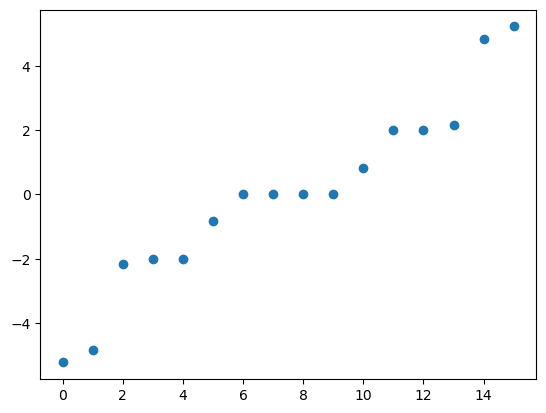

In [9]:
plt.scatter(range(len(E)),E)

In [10]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

In [11]:
hamiltonian_jax.to_sparse()

BCOO(float64[16, 16], nse=80)

In [12]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi


In [13]:
# from jax import jit
# @jit
def compute_energy(ma, parameters, ha_jax_sparse):
    psi_gs = to_array(ma, parameters)
    return psi_gs.conj().T@(ha_jax_sparse@psi_gs)

In [14]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

/home/kodo/anaconda3/lib/python3.11/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'model'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


### 3.4 Gradient of the energy

As we used jax so far, we can easily compute the gradient of the energy by simply calling one function: `jax.grad(compute_energy, argnum=1)`, where argnum signals wrt which argument we want to compute the gradient (the 0 is the model, which is not actually an array so we cannot differentiate, the second is the parameters, so that's the one

In [15]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, parameters, hamiltonian_sparse)

In [16]:
# initialise 
from tqdm import tqdm
# model = MF()
model = nk.models.RBM(alpha=1)
parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(10000)):
    # compute energy and gradient
    energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    
    # update parameters
    parameters = jax.tree_map(lambda x,y:x-0.01*y, parameters, gradient)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':energy})

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6722.21it/s]


-5.226251540158706

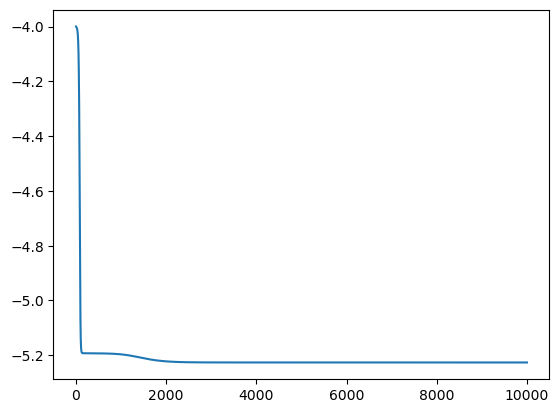

In [17]:
import matplotlib.pyplot as plt

# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['value'])
logger.data['Energy']['value'][-1]

In [18]:
logger.data['Energy']['value']

array([-3.99975801, -4.00003025, -4.00028823, ..., -5.22625154,
       -5.22625154, -5.22625154])